In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import datasets
import torchvision.transforms as transforms
from torchsummary import summary

from torch_lr_finder import LRFinder

import time
import os
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

import time
import os

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.12/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Preprocessing e Data Augmentation

In questa cella vengono definiti i **trasformatori di dati** per il dataset *FashionMNIST*, distinti per le fasi di **train**, **validation** e **test**.  
Lo scopo è aumentare la varietà dei dati di addestramento (data augmentation) e normalizzarli per migliorare la stabilità e la velocità di convergenza del modello.

- **`RandomHorizontalFlip(p=0.5)`** → ruota orizzontalmente l’immagine con probabilità 50%, utile per rendere il modello più robusto alle variazioni spaziali.  
- **`RandomRotation(10)`** → applica una rotazione casuale entro ±10°, simulando inclinazioni realistiche dei capi d’abbigliamento.  
- **`RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1))`** → introduce piccole traslazioni (fino al 10%) e variazioni di scala (±10%) per generare diversità geometrica.  
- **`ToTensor()`** → converte le immagini da formato PIL in tensori PyTorch con valori normalizzati tra 0 e 1.  
- **`Normalize((0.286,), (0.353,))`** → normalizza i tensori usando la media e la deviazione standard del dataset FashionMNIST (0.286 e 0.353 rispettivamente), per garantire una distribuzione coerente tra immagini.  
- **`RandomErasing(p=0.3, scale=(0.02, 0.15))`** → cancella casualmente piccole regioni dell’immagine con probabilità 30%, rendendo il modello più resistente a occlusioni o rumore visivo.  

Per i set di **validazione** e **test** vengono invece applicate solo le trasformazioni **ToTensor** e **Normalize**, così da mantenere i dati invariati e garantire una valutazione corretta delle prestazioni del modello.


In [ ]:
# Tecniche di Data Augmentation
data_transform = {
    "train": transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1)
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.286,), (0.353,)),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15))
    ]),
    "val":transforms.Compose([
        transforms.ToTensor(),
         transforms.Normalize((0.2860,), (0.3530,))
    ]),
    "test": transforms.Compose([
        transforms.ToTensor(),
         transforms.Normalize((0.2860,), (0.3530,))
    ])
}

# Full set che verrà poi diviso in train e val
full_train_set = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=data_transform["train"]
)

# Test set
test_set = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=data_transform["test"]
)

# Divisione in train (50k) e val (10k) con random_split
generator = torch.Generator().manual_seed(42)
train_set, val_set = random_split(
    full_train_set,
    [50000, 10000],
    generator=generator
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 316kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.60MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.4MB/s]


### Creazione dei DataLoader

In questa cella vengono definiti i **DataLoader** per i tre insiemi: *train*, *validation* e *test*.  
Il `DataLoader` è l’oggetto che gestisce il caricamento dei dati in batch, ottimizzando le prestazioni durante l’addestramento.

- **`batch_size = 128`** → specifica la dimensione del batch, ossia il numero di campioni elaborati contemporaneamente dal modello in un singolo passo di addestramento.  
  Un valore di 128 rappresenta un buon compromesso tra stabilità del gradiente e uso della memoria GPU.

#### 🔹 Train Loader
- **`shuffle=True`** → mescola i dati ad ogni epoch per evitare che il modello apprenda pattern legati all’ordine dei campioni.  
- **`num_workers=4`** → utilizza 4 processi paralleli per caricare i dati più velocemente.  
- **`pin_memory=True`** → migliora le prestazioni del trasferimento dei batch dalla RAM alla GPU.

#### 🔹 Validation e Test Loader
- **`shuffle=False`** → mantiene l’ordine dei dati, poiché durante la validazione e il test non è necessario randomizzare.  
- **`num_workers=4`** e **`pin_memory=True`** → stessi parametri per ottimizzare il caricamento dei dati, garantendo consistenza con il train loader.

In sintesi, questi `DataLoader` consentono una gestione efficiente e parallela dei dati nelle diverse fasi del training, assicurando che il modello riceva input in modo bilanciato e veloce.


In [ ]:
# Creazione dei data loader per train, val e test
batch_size = 128

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

### Definizione del modello — `FashionMNISTNet_Light`

Questa classe definisce una **rete neurale convoluzionale (CNN)** leggera progettata per il dataset *FashionMNIST*.  
L’obiettivo è mantenere un buon equilibrio tra **accuratezza** e **velocità di addestramento**, utilizzando dropout progressivi, batch normalization e un classificatore compatto.

---

#### Struttura generale
Il modello segue una classica architettura **ConvNet**, composta da una serie di blocchi convoluzionali seguiti da un classificatore completamente connesso.  
Ogni blocco include:
- **Convoluzione 2D** (`nn.Conv2d`) per estrarre le feature dalle immagini.
- **Batch Normalization** (`nn.BatchNorm2d`) per stabilizzare l’allenamento.
- **ReLU** come funzione di attivazione.
- **Dropout2d** per ridurre l’overfitting.

---

#### Layer Convoluzionali
- **`conv0`** → Primo livello più leggero (16 filtri). Serve per catturare pattern basilari (bordi, texture).  
- **`conv1`** → Aumenta la profondità a 32 filtri con un dropout minimo (0.05), utile per non perdere troppe informazioni nelle prime fasi.  
- **`conv2`** → Introduce **stride=2**, dimezzando la risoluzione spaziale e portando i canali a 64. Dropout leggermente aumentato (0.1).  
- **`conv3`** → Ulteriore downsampling e aumento dei canali a 128. Dropout a 0.15.  
- **`conv4`** → Espansione a 256 canali, mantiene la stessa risoluzione. Dropout 0.2 per aumentare la regolarizzazione.  
- **`conv5`** → Ultimo blocco convoluzionale, con 512 canali. Permette di catturare feature ad alto livello di astrazione. Dropout 0.2 per prevenire overfitting.

> La **residual connection** menzionata nel commento è concettualmente pensata per migliorare la stabilità dei layer più profondi, ma non è implementata direttamente nel codice (potrebbe essere un’estensione futura).

---

#### Classificatore finale
Il blocco `classifier` trasforma le feature estratte in predizioni di classe:
- **`AdaptiveAvgPool2d((1,1))`** → riduce ogni mappa di feature a un singolo valore medio (global average pooling).  
- **`Flatten()`** → appiattisce il tensore in un vettore.  
- **`Dropout(0.3)`** → regolarizza ulteriormente.  
- **`Linear(512, 256)` + `ReLU()`** → layer intermedio che riduce la dimensionalità e aggiunge non linearità.  
- **`Linear(256, 10)`** → layer finale che restituisce i logit per le 10 classi di *FashionMNIST*.

---

#### Inizializzazione dei pesi
Il metodo `_initialize_weights()` applica una **inizializzazione Kaiming Normal** ai pesi delle convoluzioni e dei layer lineari, garantendo una migliore distribuzione iniziale.  
Le **BatchNorm** vengono inizializzate con peso = 1 e bias = 0, in linea con le best practice per stabilizzare l’addestramento.

---

#### Forward Pass
Nel metodo `forward()` i dati attraversano sequenzialmente tutti i blocchi convoluzionali, poi vengono passati al classificatore per ottenere le predizioni finali.

---

#### Riassunto dei punti chiave
- Architettura **profonda ma leggera**, pensata per FashionMNIST.  
- **Dropout progressivo** per controllare l’overfitting.  
- **BatchNorm** in ogni layer per stabilità e velocità di convergenza.  
- **Adaptive pooling** e **classifier compatto** per ridurre il numero di parametri.  
- Struttura pronta per l’uso con **label smoothing** e altre tecniche di regolarizzazione moderna.


In [ ]:
class FashionMNISTNet_Light(nn.Module):
    def __init__(self, dropout=0.2):
      super().__init__()

      self.conv0 = nn.Sequential(
          nn.Conv2d(1, 16, kernel_size=3, padding=1, bias=False),
          nn.BatchNorm2d(16),
          nn.ReLU(inplace=True)
      )

      self.conv1 = nn.Sequential(
          nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False),
          nn.BatchNorm2d(32),
          nn.ReLU(inplace=True),
          nn.Dropout2d(0.05)
      )

      self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
      )

      self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.15)
      )

      self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2)
      )

      self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2)
      )

      self.classifier = nn.Sequential(
          nn.AdaptiveAvgPool2d((1, 1)),
          nn.Flatten(),
          nn.Dropout(0.3),
          nn.Linear(512, 256),
          nn.ReLU(inplace=True),
          nn.Dropout(0.3),
          nn.Linear(256, 10)
      )

      self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.classifier(x)
        return x

In [ ]:
model = FashionMNISTNet_Light(dropout=0.25).to(device)
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           4,608
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
         Dropout2d-7           [-1, 32, 28, 28]               0
            Conv2d-8           [-1, 64, 14, 14]          18,432
       BatchNorm2d-9           [-1, 64, 14, 14]             128
             ReLU-10           [-1, 64, 14, 14]               0
        Dropout2d-11           [-1, 64, 14, 14]               0
           Conv2d-12            [-1, 128, 7, 7]          73,728
      BatchNorm2d-13            [-1, 128, 7, 7]             256
             ReLU-14            [-1, 12

### Mixup, Loss Function e Ricerca del Learning Rate

Questa cella introduce tre elementi fondamentali per migliorare la **generalizzazione** del modello e ottimizzare la fase di training:
1. **Mixup augmentation** — tecnica di data augmentation avanzata.
2. **Loss function con label smoothing** — per una classificazione più stabile.
3. **LR Finder** — per individuare il learning rate ideale.

---

#### `mixup_data(x, y, alpha=0.2, device='cuda')`
Applica la tecnica **Mixup**, che combina casualmente coppie di immagini e label in proporzioni determinate da una variabile casuale.

- **`alpha`** → parametro della distribuzione Beta usata per calcolare il coefficiente di mescolamento `λ (lambda)`.  
  Valori più alti generano miscele più bilanciate tra due immagini.  
- **`lam = np.random.beta(alpha, alpha)`** → genera un valore `λ` tra 0 e 1.  
- **`index = torch.randperm(batch_size)`** → crea una permutazione casuale degli indici del batch per mescolare i campioni.  
- **`mixed_x = lam * x + (1 - lam) * x[index, :]`** → combina i tensori delle immagini in base al valore `λ`.  
- **`y_a, y_b = y, y[index]`** → associa a ciascun sample due etichette (una originale e una “mescolata”).  

🔹 **Output:**  
La funzione restituisce:
- **mixed_x**: batch di immagini mescolate linearmente. Ogni immagine è una combinazione di due immagini casuali del batch.
- **y_a**: primo set di etichette originale (etichette delle immagini di partenza)
- **y_b**: secondo set di etichette (etichette delle immagini mescolate con le prima)
- **lam**: coefficiente di interpolazione (compreso tra 0 e 1), controlla quanto le due immagini vengono mescolate


In [ ]:
# Tecnica di regularization Mixup
def mixup_data(x, y, alpha=0.2, device='cuda'):
    '''Restituisce input, target_a, target_b e lambda miscelati'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    '''Calcola la loss per l'output di mixup'''
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Funzione di loss con label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Ottimizzatore AdamW per lr finder
dummy_optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4,
    betas=(0.9, 0.999),
    amsgrad=False
)

lr_finder = LRFinder(
    model,
    dummy_optimizer,
    criterion,
    device=device
)

# Test del finder
lr_finder.range_test(
    train_loader,
    start_lr=1e-7,
    end_lr=1.0,
    num_iter=300,
    step_mode='exp',
    diverge_th=10,
    accumulation_steps=1,
    non_blocking_transfer=True
)

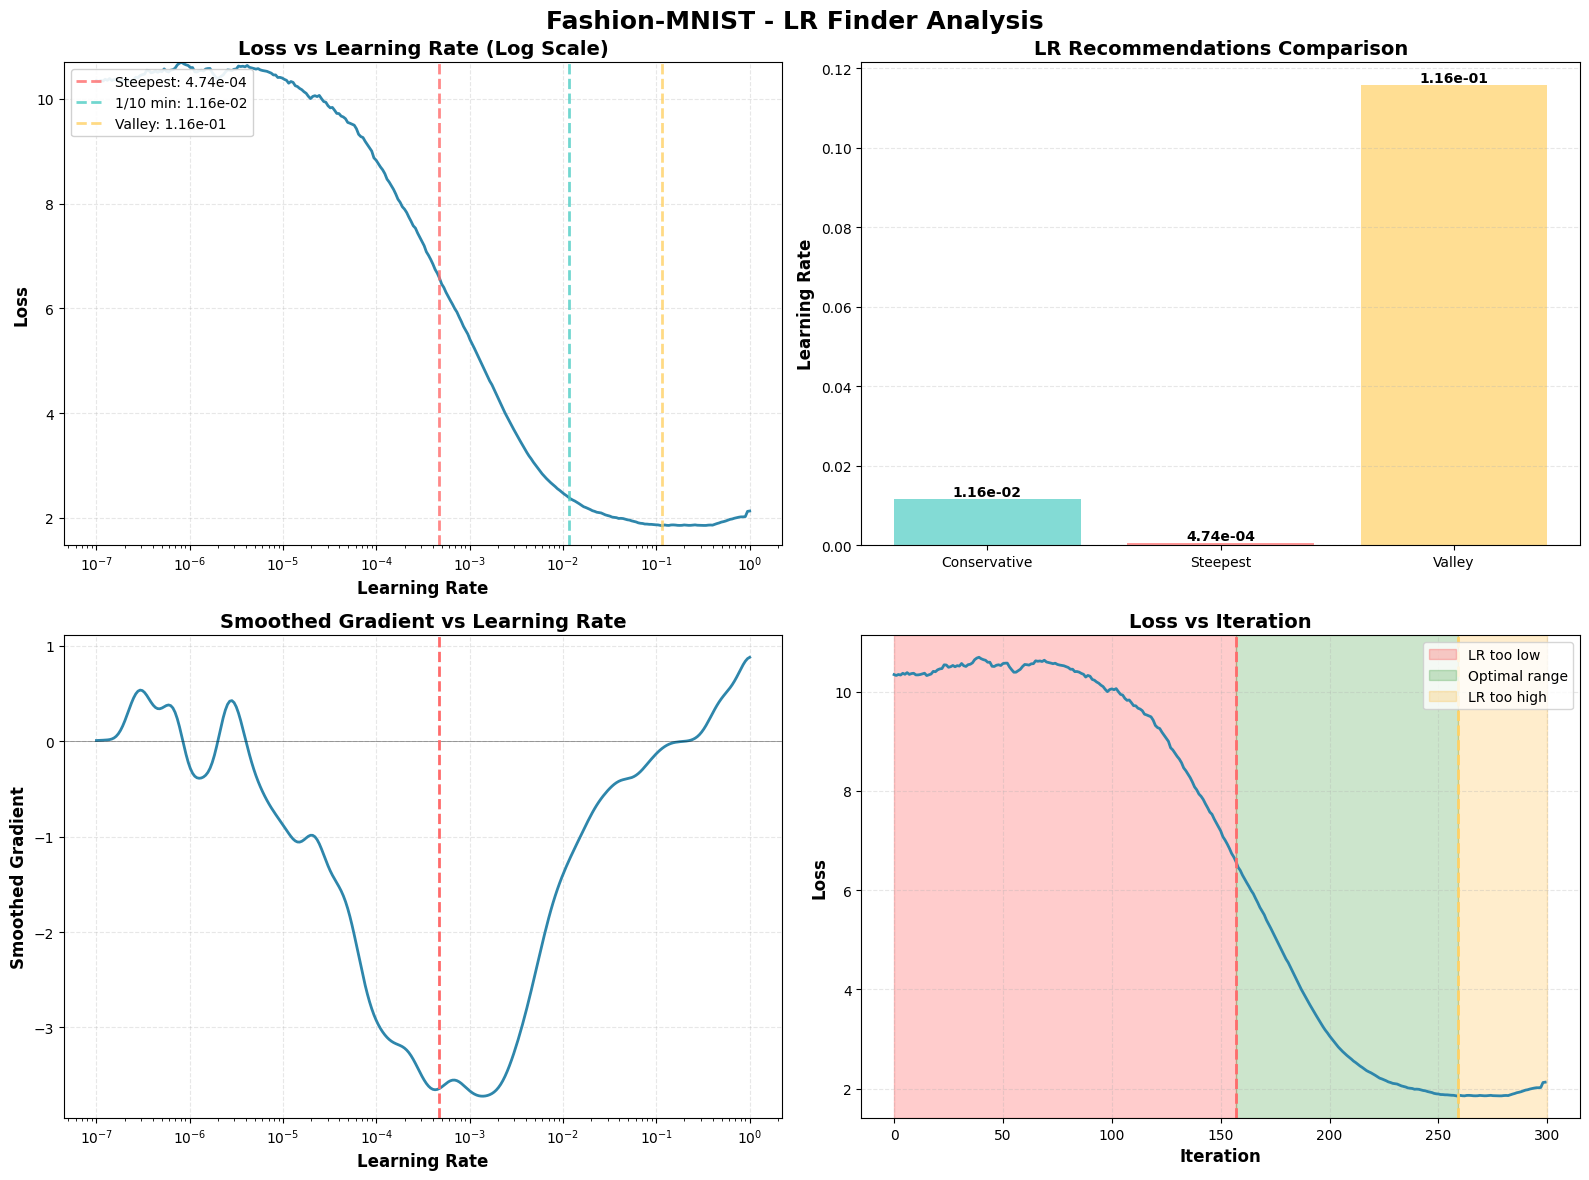


                  LR FINDER RESULTS - FASHION MNIST                   
Method                           Learning Rate         Loss Note           
----------------------------------------------------------------------
Steepest Descent                      4.74e-04       6.5767 Fast convergence
Valley Method                         1.16e-01       1.8472 Avoid divergence
1/10 Minimum                          1.16e-02            - Safe training  

🎯 FINAL RECOMMENDATION: 9.48e-04 (AGGRESSIVE (wide optimal range))
   • OneCycleLR max_lr:    2.84e-03
   • AdamW base_lr:        9.48e-04
   • Weight decay:         1e-4 to 5e-4



In [ ]:

# Estrai dati
lrs = np.array(lr_finder.history['lr'])
losses = np.array(lr_finder.history['loss'])

# ========== ALGORITMI PER TROVARE LR OTTIMALE ==========

# 1. Steepest Descent (discesa più ripida)
log_lrs = np.log10(lrs)
gradients = np.gradient(losses, log_lrs)

# Trova dove scende di più (gradiente più negativo)
# Ignora i primi 10 e ultimi 5 punti (rumore)
steepest_idx = np.argmin(gradients[10:-5]) + 10
suggested_lr_steep = lrs[steepest_idx]

# 2. Minimum Loss (punto di loss minimo)
min_loss_idx = np.argmin(losses[10:-5]) + 10
min_loss_lr = lrs[min_loss_idx]

# 3. Alternative: 1/10 del punto di loss minimo (metodo classico)
alternative_lr = min_loss_lr / 10

# 4. Valley method migliorato
try:
    # Trova dove la loss inizia a risalire stabilmente
    min_loss_global_idx = np.argmin(losses)
    valley_idx = min_loss_global_idx

    # Cerca il punto dove la loss aumenta del 10% rispetto al minimo
    for i in range(min_loss_global_idx, len(losses) - 3):
        if all(losses[i+j] > losses[min_loss_global_idx] * 1.1 for j in range(1, 4)):
            valley_idx = i
            break

    valley_lr = lrs[valley_idx]
except:
    valley_lr = min_loss_lr

# ========== PLOTTING MIGLIORATO ==========

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# --- Plot 1: Loss vs LR (Log Scale) - PRINCIPALE ---
ax1.semilogx(lrs, losses, linewidth=2, color='#2E86AB')
ax1.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Loss vs Learning Rate (Log Scale)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')

# Evidenzia i punti critici con colori più distintivi
ax1.axvline(x=suggested_lr_steep, color='#FF6B6B', linestyle='--', linewidth=2,
           alpha=0.8, label=f'Steepest: {suggested_lr_steep:.2e}')
ax1.axvline(x=alternative_lr, color='#4ECDC4', linestyle='--', linewidth=2,
           alpha=0.8, label=f'1/10 min: {alternative_lr:.2e}')
ax1.axvline(x=valley_lr, color='#FFD166', linestyle='--', linewidth=2,
           alpha=0.8, label=f'Valley: {valley_lr:.2e}')

ax1.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax1.set_ylim([min(losses)*0.8, min(max(losses), losses[0]*2)])  # Zoom sulla zona interessante

# --- Plot 2: Gradiente (Migliorato) ---
# Smooth gradient più aggressivo per ridurre rumore
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    smooth_gradients = gaussian_filter1d(gradients, sigma=5)

ax3.semilogx(lrs, smooth_gradients, linewidth=2, color='#2E86AB')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
ax3.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax3.set_ylabel('Smoothed Gradient', fontsize=12, fontweight='bold')
ax3.set_title('Smoothed Gradient vs Learning Rate', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.axvline(x=suggested_lr_steep, color='#FF6B6B', linestyle='--', linewidth=2)

# --- Plot 3: Loss vs Iteration migliorato ---
iterations = np.arange(len(losses))
ax4.plot(iterations, losses, linewidth=2, color='#2E86AB')
ax4.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax4.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax4.set_title('Loss vs Iteration', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, linestyle='--')

# Zone colorate migliorate
ax4.axvspan(0, steepest_idx, alpha=0.2, color='red', label='LR too low')
ax4.axvspan(steepest_idx, valley_idx, alpha=0.2, color='green', label='Optimal range')
ax4.axvspan(valley_idx, len(losses), alpha=0.2, color='orange', label='LR too high')

ax4.axvline(x=steepest_idx, color='#FF6B6B', linestyle='--', linewidth=2)
ax4.axvline(x=valley_idx, color='#FFD166', linestyle='--', linewidth=2)
ax4.legend(loc='upper right', fontsize=10)

# --- Plot 4: Raccomandazioni LR (Nuovo) ---
lrs_to_plot = [alternative_lr, suggested_lr_steep, valley_lr]
labels = ['Conservative', 'Steepest', 'Valley']
colors = ['#4ECDC4', '#FF6B6B', '#FFD166']

ax2.bar(labels, lrs_to_plot, color=colors, alpha=0.7)
ax2.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
ax2.set_title('LR Recommendations Comparison', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--', axis='y')

# Aggiungi valori sulle barre
for i, v in enumerate(lrs_to_plot):
    ax2.text(i, v, f'{v:.2e}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Fashion-MNIST - LR Finder Analysis', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('lr_finder_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== RACCOMANDAZIONI MIGLIORATE ==========
print(f"\n{'='*70}")
print(f"{'LR FINDER RESULTS - FASHION MNIST':^70}")
print(f"{'='*70}")

# Raccomandazione automatica basata sui risultati
if valley_lr / suggested_lr_steep > 5:  # Se c'è un ampio range ottimale
    recommended_lr = suggested_lr_steep * 2  # Più aggressivo
    recommendation_note = "AGGRESSIVE (wide optimal range)"
else:
    recommended_lr = alternative_lr  # Conservativo
    recommendation_note = "CONSERVATIVE (narrow optimal range)"

print(f"{'Method':<25} {'Learning Rate':>20} {'Loss':>12} {'Note':<15}")
print(f"{'-'*70}")
print(f"{'Steepest Descent':<25} {suggested_lr_steep:>20.2e} {losses[steepest_idx]:>12.4f} {'Fast convergence':<15}")
print(f"{'Valley Method':<25} {valley_lr:>20.2e} {losses[valley_idx]:>12.4f} {'Avoid divergence':<15}")
print(f"{'1/10 Minimum':<25} {alternative_lr:>20.2e} {'-':>12} {'Safe training':<15}")
print(f"{'='*70}")

print(f"\n🎯 FINAL RECOMMENDATION: {recommended_lr:.2e} ({recommendation_note})")
print(f"   • OneCycleLR max_lr:    {recommended_lr * 3:.2e}")
print(f"   • AdamW base_lr:        {recommended_lr:.2e}")
print(f"   • Weight decay:         1e-4 to 5e-4")
print(f"{'='*70}\n")

# Salva le raccomandazioni
lr_recommendations = {
    'steepest': suggested_lr_steep,
    'min_loss': min_loss_lr,
    'conservative': alternative_lr,
    'valley': valley_lr,
    'recommended': recommended_lr,
    'onecycle_max': recommended_lr * 3
}

# Salva in file per riferimento futuro
import json
with open('lr_recommendations.json', 'w') as f:
    json.dump({k: float(v) for k, v in lr_recommendations.items()}, f, indent=2)


In [ ]:
epochs = 150

# Ottimizzatore AdamW
optimizer = optim.AdamW(
    model.parameters(),
    lr=9.48e-04,
    weight_decay=1e-4
  )

# Scheduler OneCycleLR
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=2.84e-03,
    epochs=epochs,
    steps_per_epoch=len(train_loader)
)

In [ ]:
#  Early Stopping
class EarlyStopping:
    """Early stopping per fermare il training se la validation non migliora"""

    def __init__(self, patience=10, min_delta=0.0, mode='min'):
        """
        Args:
            patience: Quante epoche aspettare dopo l'ultimo miglioramento
            min_delta: Minimo cambiamento per considerare un miglioramento
            mode: 'min' per loss, 'max' per accuracy
        """
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = 0

    def __call__(self, score, epoch):
        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
            return True

        if self.mode == 'min':
            improved = score < (self.best_score - self.min_delta)
        else:  # 'max'
            improved = score > (self.best_score + self.min_delta)

        if improved:
            self.best_score = score
            self.best_epoch = epoch
            self.counter = 0
            return True
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False


save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Early stopping
early_stopping = EarlyStopping(patience=15, min_delta=0.001, mode='min')

# Tracking
train_losses, val_losses = [], []
train_accuracy, val_accuracy = [], []
learning_rates = []
best_val_loss = float('inf')
best_val_accuracy = 0.0

# ========== TRAINING LOOP ==========
print(f"{'='*100}")
print(f"{'TRAINING START':^100}")
print(f"{'='*100}\n")

start_time = time.time()

for epoch in range(epochs):
    epoch_start = time.time()

    # Training
    model.train()
    train_loss_epoch = 0.0
    train_correct = 0
    train_total = 0

    train_pbar = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{epochs} [TRAIN]",
        leave=False
    )

    for batch_idx, (data, label) in enumerate(train_pbar):
        data, label = data.to(device), label.to(device)
        mixed_inputs, targets_a, targets_b, lam = mixup_data(data, label, alpha=0.2, device=device)
        # Forward
        optimizer.zero_grad()
        output = model(mixed_inputs)
        loss = mixup_criterion(criterion, output, targets_a, targets_b, lam)

        # Backward
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()    # Aggiorno l'ottimizzatore
        scheduler.step()    # Aggiorno lo scheduler

        # Metriche
        train_loss_epoch += loss.item()
        _, predicted = torch.max(output.data, 1)
        train_total += label.size(0)
        train_correct += (predicted == label).sum().item()

        current_lr = optimizer.param_groups[0]['lr']
        train_pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{100 * train_correct / train_total:.2f}%",
            'lr': f"{current_lr:.2e}"
        })

    # Metriche di training
    train_loss_avg = train_loss_epoch / len(train_loader)
    epoch_train_accuracy = 100.0 * train_correct / train_total
    current_lr = optimizer.param_groups[0]['lr']

    train_losses.append(train_loss_avg)
    train_accuracy.append(epoch_train_accuracy)
    learning_rates.append(current_lr)

    # Validation
    model.eval()
    val_loss_epoch = 0.0
    val_correct = 0
    val_total = 0

    val_pbar = tqdm(
        val_loader,
        desc=f"Epoch {epoch+1}/{epochs} [VAL]  ",
        leave=False
    )

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_pbar):
            data, label = data.to(device), label.to(device)

            # Forward
            output = model(data)
            loss = criterion(output, label)

            # Metrics
            val_loss_epoch += loss.item()
            _, predicted = torch.max(output.data, 1)
            val_total += label.size(0)
            val_correct += (predicted == label).sum().item()

            val_pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{100 * val_correct / val_total:.2f}%"
            })

    # Metriche di validation
    val_loss_avg = val_loss_epoch / len(val_loader)
    epoch_val_accuracy = 100.0 * val_correct / val_total

    val_losses.append(val_loss_avg)
    val_accuracy.append(epoch_val_accuracy)

    epoch_time = time.time() - epoch_start

    print(f"\n{'='*100}")
    print(f"EPOCH {epoch+1}/{epochs} SUMMARY".center(100))
    print(f"{'='*100}")
    print(f"{'Metric':<20} {'Training':<25} {'Validation':<25} {'Best':<25}")
    print(f"{'-'*100}")
    print(f"{'Loss':<20} {train_loss_avg:<25.4f} {val_loss_avg:<25.4f} {min(val_losses):<25.4f}")
    print(f"{'Accuracy':<20} {epoch_train_accuracy:<25.2f}% {epoch_val_accuracy:<25.2f}% {max(val_accuracy):<25.2f}%")
    print(f"{'Learning Rate':<20} {current_lr:<25.2e} {'-':<25} {'-':<25}")
    print(f"{'Train/Val Gap':<20} {abs(train_loss_avg - val_loss_avg):<25.4f} {'-':<25} {'-':<25}")
    print(f"{'-'*100}")
    print(f"Epoch time: {epoch_time:.2f}s | Total time: {(time.time()-start_time)/60:.2f}min")
    print(f"{'='*100}\n")

    # Miglior modello per loss
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss_avg,
            'val_loss': val_loss_avg,
            'train_acc': epoch_train_accuracy,
            'val_acc': epoch_val_accuracy,
        }, os.path.join(save_dir, 'best_model_loss.pth'))
        print(f"✓ Best model (loss) saved: {val_loss_avg:.4f}")

    # Miglior modello per accuracy
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss_avg,
            'val_loss': val_loss_avg,
            'train_acc': epoch_train_accuracy,
            'val_acc': epoch_val_accuracy,
        }, os.path.join(save_dir, 'best_model_acc.pth'))
        print(f"✓ Best model (acc) saved: {epoch_val_accuracy:.2f}%")


    # Early stopping
    improved = early_stopping(val_loss_avg, epoch)

    if improved:
        print(f"✓ Validation loss improved!")
    else:
        print(f"⚠ No improvement for {early_stopping.counter}/{early_stopping.patience} epochs")

    if early_stopping.early_stop:
        print(f"\n{'='*100}")
        print(f"EARLY STOPPING TRIGGERED".center(100))
        print(f"{'='*100}")
        print(f"No improvement for {early_stopping.patience} consecutive epochs")
        print(f"Best epoch: {early_stopping.best_epoch + 1}")
        print(f"Best validation loss: {early_stopping.best_score:.4f}")
        print(f"{'='*100}\n")
        break

total_time = time.time() - start_time
print(f"\n{'='*100}")
print(f"TRAINING COMPLETE".center(100))
print(f"{'='*100}")
print(f"Total epochs: {epoch + 1}")
print(f"Total time: {total_time/60:.2f} minutes ({total_time/3600:.2f} hours)")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation accuracy: {best_val_accuracy:.2f}%")
print(f"Final train/val gap: {abs(train_losses[-1] - val_losses[-1]):.4f}")
print(f"{'='*100}\n")

# Modello finale
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracy': train_accuracy,
    'val_accuracy': val_accuracy,
    'learning_rates': learning_rates,
}, os.path.join(save_dir, 'final_model.pth'))

print(f"✓ Final model saved to '{save_dir}/final_model.pth'")

                                           TRAINING START                                           




                                        EPOCH 1/150 SUMMARY                                         
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 2.3310                    1.7406                    1.7406                   
Accuracy             15.61                    % 41.62                    % 41.62                    %
Learning Rate        1.17e-04                  -                         -                        
Train/Val Gap        0.5905                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.54s | Total time: 0.51min

✓ Best model (loss) saved: 1.7406
✓ Best model (acc) saved: 41.62%
✓ Validation loss improved!



                                        EPOCH 2/150 SUMMARY                                         
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.9623                    1.5010                    1.5010                   
Accuracy             22.93                    % 55.55                    % 55.55                    %
Learning Rate        1.27e-04                  -                         -                        
Train/Val Gap        0.4612                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.63s | Total time: 1.02min

✓ Best model (loss) saved: 1.5010
✓ Best model (acc) saved: 55.55%
✓ Validation loss improved!



                                        EPOCH 3/150 SUMMARY                                         
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.7570                    1.3526                    1.3526                   
Accuracy             29.59                    % 67.60                    % 67.60                    %
Learning Rate        1.43e-04                  -                         -                        
Train/Val Gap        0.4044                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.59s | Total time: 1.50min

✓ Best model (loss) saved: 1.3526
✓ Best model (acc) saved: 67.60%
✓ Validation loss improved!



                                        EPOCH 4/150 SUMMARY                                         
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.6673                    1.2366                    1.2366                   
Accuracy             33.97                    % 70.32                    % 70.32                    %
Learning Rate        1.66e-04                  -                         -                        
Train/Val Gap        0.4307                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.92s | Total time: 1.98min

✓ Best model (loss) saved: 1.2366
✓ Best model (acc) saved: 70.32%
✓ Validation loss improved!



                                        EPOCH 5/150 SUMMARY                                         
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.5625                    1.1581                    1.1581                   
Accuracy             36.21                    % 72.57                    % 72.57                    %
Learning Rate        1.96e-04                  -                         -                        
Train/Val Gap        0.4044                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.73s | Total time: 2.46min

✓ Best model (loss) saved: 1.1581
✓ Best model (acc) saved: 72.57%
✓ Validation loss improved!



                                        EPOCH 6/150 SUMMARY                                         
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.5101                    1.1041                    1.1041                   
Accuracy             33.78                    % 73.12                    % 73.12                    %
Learning Rate        2.31e-04                  -                         -                        
Train/Val Gap        0.4060                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.69s | Total time: 2.96min

✓ Best model (loss) saved: 1.1041
✓ Best model (acc) saved: 73.12%
✓ Validation loss improved!



                                        EPOCH 7/150 SUMMARY                                         
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.4606                    1.0731                    1.0731                   
Accuracy             37.20                    % 74.04                    % 74.04                    %
Learning Rate        2.73e-04                  -                         -                        
Train/Val Gap        0.3875                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.76s | Total time: 3.44min

✓ Best model (loss) saved: 1.0731
✓ Best model (acc) saved: 74.04%
✓ Validation loss improved!



                                        EPOCH 8/150 SUMMARY                                         
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.4113                    1.0297                    1.0297                   
Accuracy             41.25                    % 75.68                    % 75.68                    %
Learning Rate        3.21e-04                  -                         -                        
Train/Val Gap        0.3816                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.57s | Total time: 3.92min

✓ Best model (loss) saved: 1.0297
✓ Best model (acc) saved: 75.68%
✓ Validation loss improved!



                                        EPOCH 9/150 SUMMARY                                         
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.3731                    1.0038                    1.0038                   
Accuracy             39.56                    % 76.41                    % 76.41                    %
Learning Rate        3.74e-04                  -                         -                        
Train/Val Gap        0.3694                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.95s | Total time: 4.40min

✓ Best model (loss) saved: 1.0038
✓ Best model (acc) saved: 76.41%
✓ Validation loss improved!



                                        EPOCH 10/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.3409                    0.9770                    0.9770                   
Accuracy             41.15                    % 77.73                    % 77.73                    %
Learning Rate        4.33e-04                  -                         -                        
Train/Val Gap        0.3639                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.80s | Total time: 4.90min

✓ Best model (loss) saved: 0.9770
✓ Best model (acc) saved: 77.73%
✓ Checkpoint saved at epoch 10
✓ Validation loss improved!



                                        EPOCH 11/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.2968                    0.9449                    0.9449                   
Accuracy             45.24                    % 79.44                    % 79.44                    %
Learning Rate        4.96e-04                  -                         -                        
Train/Val Gap        0.3519                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.96s | Total time: 5.39min

✓ Best model (loss) saved: 0.9449
✓ Best model (acc) saved: 79.44%
✓ Validation loss improved!



                                        EPOCH 12/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.2687                    0.9244                    0.9244                   
Accuracy             40.29                    % 80.26                    % 80.26                    %
Learning Rate        5.65e-04                  -                         -                        
Train/Val Gap        0.3443                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.74s | Total time: 5.87min

✓ Best model (loss) saved: 0.9244
✓ Best model (acc) saved: 80.26%
✓ Validation loss improved!



                                        EPOCH 13/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.2518                    0.9089                    0.9089                   
Accuracy             43.39                    % 81.13                    % 81.13                    %
Learning Rate        6.38e-04                  -                         -                        
Train/Val Gap        0.3429                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.77s | Total time: 6.35min

✓ Best model (loss) saved: 0.9089
✓ Best model (acc) saved: 81.13%
✓ Validation loss improved!



                                        EPOCH 14/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.2306                    0.9122                    0.9089                   
Accuracy             48.51                    % 80.65                    % 81.13                    %
Learning Rate        7.15e-04                  -                         -                        
Train/Val Gap        0.3184                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.43s | Total time: 6.82min

⚠ No improvement for 1/15 epochs



                                        EPOCH 15/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.1933                    0.8703                    0.8703                   
Accuracy             47.43                    % 83.11                    % 83.11                    %
Learning Rate        7.95e-04                  -                         -                        
Train/Val Gap        0.3230                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.41s | Total time: 7.31min

✓ Best model (loss) saved: 0.8703
✓ Best model (acc) saved: 83.11%
✓ Validation loss improved!



                                        EPOCH 16/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.2033                    0.8519                    0.8519                   
Accuracy             45.66                    % 83.78                    % 83.78                    %
Learning Rate        8.79e-04                  -                         -                        
Train/Val Gap        0.3514                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.34s | Total time: 7.79min

✓ Best model (loss) saved: 0.8519
✓ Best model (acc) saved: 83.78%
✓ Validation loss improved!



                                        EPOCH 17/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.1865                    0.8434                    0.8434                   
Accuracy             47.54                    % 84.44                    % 84.44                    %
Learning Rate        9.66e-04                  -                         -                        
Train/Val Gap        0.3431                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.55s | Total time: 8.26min

✓ Best model (loss) saved: 0.8434
✓ Best model (acc) saved: 84.44%
✓ Validation loss improved!



                                        EPOCH 18/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.1364                    0.8369                    0.8369                   
Accuracy             46.65                    % 84.67                    % 84.67                    %
Learning Rate        1.06e-03                  -                         -                        
Train/Val Gap        0.2994                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.91s | Total time: 8.75min

✓ Best model (loss) saved: 0.8369
✓ Best model (acc) saved: 84.67%
✓ Validation loss improved!



                                        EPOCH 19/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.1716                    0.8473                    0.8369                   
Accuracy             45.98                    % 84.68                    % 84.68                    %
Learning Rate        1.15e-03                  -                         -                        
Train/Val Gap        0.3244                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.15s | Total time: 9.25min

✓ Best model (acc) saved: 84.68%
⚠ No improvement for 1/15 epochs



                                        EPOCH 20/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.1364                    0.8184                    0.8184                   
Accuracy             47.94                    % 86.33                    % 86.33                    %
Learning Rate        1.24e-03                  -                         -                        
Train/Val Gap        0.3180                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.00s | Total time: 9.73min

✓ Best model (loss) saved: 0.8184
✓ Best model (acc) saved: 86.33%
✓ Checkpoint saved at epoch 20
✓ Validation loss improved!



                                        EPOCH 21/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.1113                    0.8167                    0.8167                   
Accuracy             44.59                    % 85.58                    % 86.33                    %
Learning Rate        1.33e-03                  -                         -                        
Train/Val Gap        0.2946                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.70s | Total time: 10.21min

✓ Best model (loss) saved: 0.8167
✓ Validation loss improved!



                                        EPOCH 22/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.1165                    0.7942                    0.7942                   
Accuracy             49.26                    % 86.62                    % 86.62                    %
Learning Rate        1.43e-03                  -                         -                        
Train/Val Gap        0.3223                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.03s | Total time: 10.70min

✓ Best model (loss) saved: 0.7942
✓ Best model (acc) saved: 86.62%
✓ Validation loss improved!



                                        EPOCH 23/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0999                    0.7879                    0.7879                   
Accuracy             49.52                    % 87.36                    % 87.36                    %
Learning Rate        1.52e-03                  -                         -                        
Train/Val Gap        0.3120                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.00s | Total time: 11.20min

✓ Best model (loss) saved: 0.7879
✓ Best model (acc) saved: 87.36%
✓ Validation loss improved!



                                        EPOCH 24/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0820                    0.7799                    0.7799                   
Accuracy             48.22                    % 87.10                    % 87.36                    %
Learning Rate        1.62e-03                  -                         -                        
Train/Val Gap        0.3022                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.84s | Total time: 11.68min

✓ Best model (loss) saved: 0.7799
✓ Validation loss improved!



                                        EPOCH 25/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0613                    0.7961                    0.7799                   
Accuracy             48.16                    % 87.20                    % 87.36                    %
Learning Rate        1.71e-03                  -                         -                        
Train/Val Gap        0.2653                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.67s | Total time: 12.16min

⚠ No improvement for 1/15 epochs



                                        EPOCH 26/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0509                    0.7826                    0.7799                   
Accuracy             47.92                    % 87.32                    % 87.36                    %
Learning Rate        1.81e-03                  -                         -                        
Train/Val Gap        0.2683                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.11s | Total time: 12.65min

⚠ No improvement for 2/15 epochs



                                        EPOCH 27/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0635                    0.7700                    0.7700                   
Accuracy             49.61                    % 87.81                    % 87.81                    %
Learning Rate        1.90e-03                  -                         -                        
Train/Val Gap        0.2935                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.50s | Total time: 13.14min

✓ Best model (loss) saved: 0.7700
✓ Best model (acc) saved: 87.81%
✓ Validation loss improved!



                                        EPOCH 28/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0773                    0.7685                    0.7685                   
Accuracy             52.08                    % 87.62                    % 87.81                    %
Learning Rate        1.99e-03                  -                         -                        
Train/Val Gap        0.3088                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.70s | Total time: 13.64min

✓ Best model (loss) saved: 0.7685
✓ Validation loss improved!



                                        EPOCH 29/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0598                    0.7517                    0.7517                   
Accuracy             47.34                    % 88.40                    % 88.40                    %
Learning Rate        2.07e-03                  -                         -                        
Train/Val Gap        0.3081                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.31s | Total time: 14.12min

✓ Best model (loss) saved: 0.7517
✓ Best model (acc) saved: 88.40%
✓ Validation loss improved!



                                        EPOCH 30/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0461                    0.7508                    0.7508                   
Accuracy             47.83                    % 88.44                    % 88.44                    %
Learning Rate        2.16e-03                  -                         -                        
Train/Val Gap        0.2952                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.13s | Total time: 14.61min

✓ Best model (loss) saved: 0.7508
✓ Best model (acc) saved: 88.44%
✓ Checkpoint saved at epoch 30
⚠ No improvement for 1/15 epochs



                                        EPOCH 31/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0369                    0.7462                    0.7462                   
Accuracy             47.87                    % 88.74                    % 88.74                    %
Learning Rate        2.24e-03                  -                         -                        
Train/Val Gap        0.2907                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.92s | Total time: 15.10min

✓ Best model (loss) saved: 0.7462
✓ Best model (acc) saved: 88.74%
✓ Validation loss improved!



                                        EPOCH 32/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0584                    0.7406                    0.7406                   
Accuracy             46.46                    % 89.22                    % 89.22                    %
Learning Rate        2.32e-03                  -                         -                        
Train/Val Gap        0.3178                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.98s | Total time: 15.60min

✓ Best model (loss) saved: 0.7406
✓ Best model (acc) saved: 89.22%
✓ Validation loss improved!



                                        EPOCH 33/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0097                    0.7324                    0.7324                   
Accuracy             47.29                    % 89.20                    % 89.22                    %
Learning Rate        2.39e-03                  -                         -                        
Train/Val Gap        0.2773                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.23s | Total time: 16.09min

✓ Best model (loss) saved: 0.7324
✓ Validation loss improved!



                                        EPOCH 34/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0332                    0.7339                    0.7324                   
Accuracy             50.79                    % 89.32                    % 89.32                    %
Learning Rate        2.46e-03                  -                         -                        
Train/Val Gap        0.2993                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.77s | Total time: 16.57min

✓ Best model (acc) saved: 89.32%
⚠ No improvement for 1/15 epochs



                                        EPOCH 35/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0230                    0.7504                    0.7324                   
Accuracy             48.39                    % 88.88                    % 89.32                    %
Learning Rate        2.52e-03                  -                         -                        
Train/Val Gap        0.2726                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.24s | Total time: 17.04min

⚠ No improvement for 2/15 epochs



                                        EPOCH 36/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0281                    0.7233                    0.7233                   
Accuracy             49.96                    % 89.97                    % 89.97                    %
Learning Rate        2.58e-03                  -                         -                        
Train/Val Gap        0.3048                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.00s | Total time: 17.54min

✓ Best model (loss) saved: 0.7233
✓ Best model (acc) saved: 89.97%
✓ Validation loss improved!



                                        EPOCH 37/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0231                    0.7287                    0.7233                   
Accuracy             47.53                    % 89.77                    % 89.97                    %
Learning Rate        2.63e-03                  -                         -                        
Train/Val Gap        0.2944                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.31s | Total time: 18.03min

⚠ No improvement for 1/15 epochs



                                        EPOCH 38/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0389                    0.7308                    0.7233                   
Accuracy             46.67                    % 89.67                    % 89.97                    %
Learning Rate        2.68e-03                  -                         -                        
Train/Val Gap        0.3081                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.95s | Total time: 18.51min

⚠ No improvement for 2/15 epochs



                                        EPOCH 39/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0146                    0.7286                    0.7233                   
Accuracy             51.66                    % 89.89                    % 89.97                    %
Learning Rate        2.72e-03                  -                         -                        
Train/Val Gap        0.2860                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.00s | Total time: 18.99min

⚠ No improvement for 3/15 epochs



                                        EPOCH 40/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9905                    0.7315                    0.7233                   
Accuracy             48.93                    % 89.19                    % 89.97                    %
Learning Rate        2.76e-03                  -                         -                        
Train/Val Gap        0.2591                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.24s | Total time: 19.50min

✓ Checkpoint saved at epoch 40
⚠ No improvement for 4/15 epochs



                                        EPOCH 41/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9888                    0.7173                    0.7173                   
Accuracy             46.25                    % 90.11                    % 90.11                    %
Learning Rate        2.79e-03                  -                         -                        
Train/Val Gap        0.2715                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.20s | Total time: 19.99min

✓ Best model (loss) saved: 0.7173
✓ Best model (acc) saved: 90.11%
✓ Validation loss improved!



                                        EPOCH 42/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0200                    0.7183                    0.7173                   
Accuracy             46.96                    % 90.33                    % 90.33                    %
Learning Rate        2.81e-03                  -                         -                        
Train/Val Gap        0.3017                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.32s | Total time: 20.48min

✓ Best model (acc) saved: 90.33%
⚠ No improvement for 1/15 epochs



                                        EPOCH 43/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9973                    0.7124                    0.7124                   
Accuracy             49.64                    % 90.55                    % 90.55                    %
Learning Rate        2.83e-03                  -                         -                        
Train/Val Gap        0.2849                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.32s | Total time: 20.97min

✓ Best model (loss) saved: 0.7124
✓ Best model (acc) saved: 90.55%
✓ Validation loss improved!



                                        EPOCH 44/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9875                    0.7255                    0.7124                   
Accuracy             46.50                    % 89.68                    % 90.55                    %
Learning Rate        2.84e-03                  -                         -                        
Train/Val Gap        0.2619                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.05s | Total time: 21.45min

⚠ No improvement for 1/15 epochs



                                        EPOCH 45/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0005                    0.7133                    0.7124                   
Accuracy             49.87                    % 90.41                    % 90.55                    %
Learning Rate        2.84e-03                  -                         -                        
Train/Val Gap        0.2872                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.12s | Total time: 21.92min

⚠ No improvement for 2/15 epochs



                                        EPOCH 46/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9958                    0.7130                    0.7124                   
Accuracy             51.43                    % 90.63                    % 90.63                    %
Learning Rate        2.84e-03                  -                         -                        
Train/Val Gap        0.2828                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 28.39s | Total time: 22.39min

✓ Best model (acc) saved: 90.63%
⚠ No improvement for 3/15 epochs



                                        EPOCH 47/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0105                    0.7122                    0.7122                   
Accuracy             51.83                    % 90.55                    % 90.63                    %
Learning Rate        2.84e-03                  -                         -                        
Train/Val Gap        0.2983                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.28s | Total time: 22.88min

✓ Best model (loss) saved: 0.7122
⚠ No improvement for 4/15 epochs



                                        EPOCH 48/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9941                    0.7061                    0.7061                   
Accuracy             49.56                    % 90.51                    % 90.63                    %
Learning Rate        2.83e-03                  -                         -                        
Train/Val Gap        0.2880                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.07s | Total time: 23.37min

✓ Best model (loss) saved: 0.7061
✓ Validation loss improved!



                                        EPOCH 49/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9877                    0.7128                    0.7061                   
Accuracy             44.97                    % 90.32                    % 90.63                    %
Learning Rate        2.83e-03                  -                         -                        
Train/Val Gap        0.2750                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.94s | Total time: 23.87min

⚠ No improvement for 1/15 epochs



                                        EPOCH 50/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 1.0135                    0.7116                    0.7061                   
Accuracy             49.98                    % 90.46                    % 90.63                    %
Learning Rate        2.82e-03                  -                         -                        
Train/Val Gap        0.3019                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.30s | Total time: 24.36min

✓ Checkpoint saved at epoch 50
⚠ No improvement for 2/15 epochs



                                        EPOCH 51/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9680                    0.7388                    0.7061                   
Accuracy             50.33                    % 88.97                    % 90.63                    %
Learning Rate        2.82e-03                  -                         -                        
Train/Val Gap        0.2292                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 31.95s | Total time: 24.89min

⚠ No improvement for 3/15 epochs



                                        EPOCH 52/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9855                    0.7049                    0.7049                   
Accuracy             47.38                    % 90.74                    % 90.74                    %
Learning Rate        2.81e-03                  -                         -                        
Train/Val Gap        0.2806                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.00s | Total time: 25.39min

✓ Best model (loss) saved: 0.7049
✓ Best model (acc) saved: 90.74%
✓ Validation loss improved!



                                        EPOCH 53/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9883                    0.7088                    0.7049                   
Accuracy             50.48                    % 90.63                    % 90.74                    %
Learning Rate        2.80e-03                  -                         -                        
Train/Val Gap        0.2795                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.03s | Total time: 25.87min

⚠ No improvement for 1/15 epochs



                                        EPOCH 54/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9765                    0.7013                    0.7013                   
Accuracy             46.46                    % 90.86                    % 90.86                    %
Learning Rate        2.79e-03                  -                         -                        
Train/Val Gap        0.2752                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.41s | Total time: 26.36min

✓ Best model (loss) saved: 0.7013
✓ Best model (acc) saved: 90.86%
✓ Validation loss improved!



                                        EPOCH 55/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9849                    0.6964                    0.6964                   
Accuracy             49.07                    % 90.81                    % 90.86                    %
Learning Rate        2.78e-03                  -                         -                        
Train/Val Gap        0.2885                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.15s | Total time: 26.85min

✓ Best model (loss) saved: 0.6964
✓ Validation loss improved!



                                        EPOCH 56/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9647                    0.7032                    0.6964                   
Accuracy             49.09                    % 90.69                    % 90.86                    %
Learning Rate        2.76e-03                  -                         -                        
Train/Val Gap        0.2615                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.07s | Total time: 27.35min

⚠ No improvement for 1/15 epochs



                                        EPOCH 57/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9836                    0.6969                    0.6964                   
Accuracy             46.29                    % 90.87                    % 90.87                    %
Learning Rate        2.75e-03                  -                         -                        
Train/Val Gap        0.2867                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.50s | Total time: 27.85min

✓ Best model (acc) saved: 90.87%
⚠ No improvement for 2/15 epochs



                                        EPOCH 58/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9693                    0.7000                    0.6964                   
Accuracy             48.78                    % 90.99                    % 90.99                    %
Learning Rate        2.73e-03                  -                         -                        
Train/Val Gap        0.2693                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.61s | Total time: 28.34min

✓ Best model (acc) saved: 90.99%
⚠ No improvement for 3/15 epochs



                                        EPOCH 59/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9494                    0.6856                    0.6856                   
Accuracy             48.68                    % 91.79                    % 91.79                    %
Learning Rate        2.72e-03                  -                         -                        
Train/Val Gap        0.2638                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.14s | Total time: 28.83min

✓ Best model (loss) saved: 0.6856
✓ Best model (acc) saved: 91.79%
✓ Validation loss improved!



                                        EPOCH 60/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9727                    0.6873                    0.6856                   
Accuracy             48.06                    % 91.53                    % 91.79                    %
Learning Rate        2.70e-03                  -                         -                        
Train/Val Gap        0.2855                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.78s | Total time: 29.32min

✓ Checkpoint saved at epoch 60
⚠ No improvement for 1/15 epochs



                                        EPOCH 61/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9695                    0.6930                    0.6856                   
Accuracy             47.87                    % 91.21                    % 91.79                    %
Learning Rate        2.68e-03                  -                         -                        
Train/Val Gap        0.2766                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.35s | Total time: 29.81min

⚠ No improvement for 2/15 epochs



                                        EPOCH 62/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9563                    0.6943                    0.6856                   
Accuracy             51.96                    % 91.20                    % 91.79                    %
Learning Rate        2.66e-03                  -                         -                        
Train/Val Gap        0.2621                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.12s | Total time: 30.30min

⚠ No improvement for 3/15 epochs



                                        EPOCH 63/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9754                    0.6952                    0.6856                   
Accuracy             49.27                    % 91.19                    % 91.79                    %
Learning Rate        2.64e-03                  -                         -                        
Train/Val Gap        0.2802                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.38s | Total time: 30.79min

⚠ No improvement for 4/15 epochs



                                        EPOCH 64/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9446                    0.6927                    0.6856                   
Accuracy             49.54                    % 91.21                    % 91.79                    %
Learning Rate        2.62e-03                  -                         -                        
Train/Val Gap        0.2519                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.31s | Total time: 31.28min

⚠ No improvement for 5/15 epochs



                                        EPOCH 65/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9746                    0.6908                    0.6856                   
Accuracy             50.84                    % 91.27                    % 91.79                    %
Learning Rate        2.59e-03                  -                         -                        
Train/Val Gap        0.2838                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.97s | Total time: 31.78min

⚠ No improvement for 6/15 epochs



                                        EPOCH 66/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9608                    0.6870                    0.6856                   
Accuracy             52.73                    % 91.34                    % 91.79                    %
Learning Rate        2.57e-03                  -                         -                        
Train/Val Gap        0.2738                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.99s | Total time: 32.28min

⚠ No improvement for 7/15 epochs



                                        EPOCH 67/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9652                    0.6922                    0.6856                   
Accuracy             51.28                    % 91.42                    % 91.79                    %
Learning Rate        2.54e-03                  -                         -                        
Train/Val Gap        0.2730                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.76s | Total time: 32.77min

⚠ No improvement for 8/15 epochs



                                        EPOCH 68/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9762                    0.6950                    0.6856                   
Accuracy             47.61                    % 91.16                    % 91.79                    %
Learning Rate        2.52e-03                  -                         -                        
Train/Val Gap        0.2812                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.22s | Total time: 33.28min

⚠ No improvement for 9/15 epochs



                                        EPOCH 69/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9498                    0.6883                    0.6856                   
Accuracy             49.16                    % 91.62                    % 91.79                    %
Learning Rate        2.49e-03                  -                         -                        
Train/Val Gap        0.2615                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.02s | Total time: 33.78min

⚠ No improvement for 10/15 epochs



                                        EPOCH 70/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9641                    0.6898                    0.6856                   
Accuracy             48.19                    % 91.75                    % 91.79                    %
Learning Rate        2.46e-03                  -                         -                        
Train/Val Gap        0.2743                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.50s | Total time: 34.27min

✓ Checkpoint saved at epoch 70
⚠ No improvement for 11/15 epochs



                                        EPOCH 71/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9505                    0.6898                    0.6856                   
Accuracy             49.46                    % 91.52                    % 91.79                    %
Learning Rate        2.43e-03                  -                         -                        
Train/Val Gap        0.2607                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.13s | Total time: 34.76min

⚠ No improvement for 12/15 epochs



                                        EPOCH 72/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9516                    0.6829                    0.6829                   
Accuracy             49.11                    % 91.83                    % 91.83                    %
Learning Rate        2.40e-03                  -                         -                        
Train/Val Gap        0.2687                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.57s | Total time: 35.26min

✓ Best model (loss) saved: 0.6829
✓ Best model (acc) saved: 91.83%
✓ Validation loss improved!



                                        EPOCH 73/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9774                    0.6893                    0.6829                   
Accuracy             48.38                    % 91.69                    % 91.83                    %
Learning Rate        2.37e-03                  -                         -                        
Train/Val Gap        0.2881                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.63s | Total time: 35.76min

⚠ No improvement for 1/15 epochs



                                        EPOCH 74/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9492                    0.6827                    0.6827                   
Accuracy             53.71                    % 91.97                    % 91.97                    %
Learning Rate        2.34e-03                  -                         -                        
Train/Val Gap        0.2665                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.56s | Total time: 36.27min

✓ Best model (loss) saved: 0.6827
✓ Best model (acc) saved: 91.97%
⚠ No improvement for 2/15 epochs



                                        EPOCH 75/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9579                    0.6864                    0.6827                   
Accuracy             47.99                    % 91.67                    % 91.97                    %
Learning Rate        2.31e-03                  -                         -                        
Train/Val Gap        0.2716                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.98s | Total time: 36.77min

⚠ No improvement for 3/15 epochs



                                        EPOCH 76/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9644                    0.6848                    0.6827                   
Accuracy             49.77                    % 91.96                    % 91.97                    %
Learning Rate        2.27e-03                  -                         -                        
Train/Val Gap        0.2796                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.63s | Total time: 37.28min

⚠ No improvement for 4/15 epochs



                                        EPOCH 77/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9570                    0.6779                    0.6779                   
Accuracy             52.92                    % 91.77                    % 91.97                    %
Learning Rate        2.24e-03                  -                         -                        
Train/Val Gap        0.2791                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.83s | Total time: 37.78min

✓ Best model (loss) saved: 0.6779
✓ Validation loss improved!



                                        EPOCH 78/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9686                    0.6752                    0.6752                   
Accuracy             53.68                    % 92.32                    % 92.32                    %
Learning Rate        2.20e-03                  -                         -                        
Train/Val Gap        0.2934                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.31s | Total time: 38.28min

✓ Best model (loss) saved: 0.6752
✓ Best model (acc) saved: 92.32%
✓ Validation loss improved!



                                        EPOCH 79/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9558                    0.6828                    0.6752                   
Accuracy             51.73                    % 92.06                    % 92.32                    %
Learning Rate        2.17e-03                  -                         -                        
Train/Val Gap        0.2730                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 31.07s | Total time: 38.80min

⚠ No improvement for 1/15 epochs



                                        EPOCH 80/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9445                    0.6773                    0.6752                   
Accuracy             51.11                    % 92.00                    % 92.32                    %
Learning Rate        2.13e-03                  -                         -                        
Train/Val Gap        0.2672                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.03s | Total time: 39.30min

✓ Checkpoint saved at epoch 80
⚠ No improvement for 2/15 epochs



                                        EPOCH 81/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9485                    0.6797                    0.6752                   
Accuracy             49.73                    % 91.80                    % 92.32                    %
Learning Rate        2.09e-03                  -                         -                        
Train/Val Gap        0.2688                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.08s | Total time: 39.81min

⚠ No improvement for 3/15 epochs



                                        EPOCH 82/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9406                    0.6898                    0.6752                   
Accuracy             50.72                    % 91.78                    % 92.32                    %
Learning Rate        2.06e-03                  -                         -                        
Train/Val Gap        0.2508                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.52s | Total time: 40.31min

⚠ No improvement for 4/15 epochs



                                        EPOCH 83/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9570                    0.6794                    0.6752                   
Accuracy             52.18                    % 91.94                    % 92.32                    %
Learning Rate        2.02e-03                  -                         -                        
Train/Val Gap        0.2776                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 31.79s | Total time: 40.84min

⚠ No improvement for 5/15 epochs



                                        EPOCH 84/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9532                    0.6725                    0.6725                   
Accuracy             49.77                    % 92.12                    % 92.32                    %
Learning Rate        1.98e-03                  -                         -                        
Train/Val Gap        0.2807                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.14s | Total time: 41.35min

✓ Best model (loss) saved: 0.6725
✓ Validation loss improved!



                                        EPOCH 85/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9444                    0.6756                    0.6725                   
Accuracy             51.54                    % 92.26                    % 92.32                    %
Learning Rate        1.94e-03                  -                         -                        
Train/Val Gap        0.2688                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.72s | Total time: 41.84min

⚠ No improvement for 1/15 epochs



                                        EPOCH 86/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9557                    0.6713                    0.6713                   
Accuracy             48.03                    % 92.34                    % 92.34                    %
Learning Rate        1.90e-03                  -                         -                        
Train/Val Gap        0.2844                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.49s | Total time: 42.35min

✓ Best model (loss) saved: 0.6713
✓ Best model (acc) saved: 92.34%
✓ Validation loss improved!



                                        EPOCH 87/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9388                    0.6748                    0.6713                   
Accuracy             51.89                    % 92.07                    % 92.34                    %
Learning Rate        1.86e-03                  -                         -                        
Train/Val Gap        0.2640                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.01s | Total time: 42.85min

⚠ No improvement for 1/15 epochs



                                        EPOCH 88/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9353                    0.6751                    0.6713                   
Accuracy             49.38                    % 92.10                    % 92.34                    %
Learning Rate        1.82e-03                  -                         -                        
Train/Val Gap        0.2602                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.00s | Total time: 43.35min

⚠ No improvement for 2/15 epochs



                                        EPOCH 89/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9380                    0.6770                    0.6713                   
Accuracy             53.46                    % 92.15                    % 92.34                    %
Learning Rate        1.78e-03                  -                         -                        
Train/Val Gap        0.2610                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 31.17s | Total time: 43.87min

⚠ No improvement for 3/15 epochs



                                        EPOCH 90/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9402                    0.6791                    0.6713                   
Accuracy             51.60                    % 92.21                    % 92.34                    %
Learning Rate        1.74e-03                  -                         -                        
Train/Val Gap        0.2611                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.64s | Total time: 44.38min

✓ Checkpoint saved at epoch 90
⚠ No improvement for 4/15 epochs



                                        EPOCH 91/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9409                    0.6709                    0.6709                   
Accuracy             47.51                    % 92.38                    % 92.38                    %
Learning Rate        1.69e-03                  -                         -                        
Train/Val Gap        0.2700                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.61s | Total time: 44.89min

✓ Best model (loss) saved: 0.6709
✓ Best model (acc) saved: 92.38%
⚠ No improvement for 5/15 epochs



                                        EPOCH 92/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9239                    0.6672                    0.6672                   
Accuracy             51.95                    % 92.46                    % 92.46                    %
Learning Rate        1.65e-03                  -                         -                        
Train/Val Gap        0.2568                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.50s | Total time: 45.40min

✓ Best model (loss) saved: 0.6672
✓ Best model (acc) saved: 92.46%
✓ Validation loss improved!



                                        EPOCH 93/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9445                    0.6639                    0.6639                   
Accuracy             50.91                    % 92.34                    % 92.46                    %
Learning Rate        1.61e-03                  -                         -                        
Train/Val Gap        0.2806                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 31.13s | Total time: 45.92min

✓ Best model (loss) saved: 0.6639
✓ Validation loss improved!



                                        EPOCH 94/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9285                    0.6734                    0.6639                   
Accuracy             48.56                    % 91.82                    % 92.46                    %
Learning Rate        1.57e-03                  -                         -                        
Train/Val Gap        0.2550                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.39s | Total time: 46.43min

⚠ No improvement for 1/15 epochs



                                        EPOCH 95/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9207                    0.6681                    0.6639                   
Accuracy             49.20                    % 92.32                    % 92.46                    %
Learning Rate        1.53e-03                  -                         -                        
Train/Val Gap        0.2526                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.19s | Total time: 46.94min

⚠ No improvement for 2/15 epochs



                                        EPOCH 96/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9119                    0.6739                    0.6639                   
Accuracy             53.92                    % 92.19                    % 92.46                    %
Learning Rate        1.48e-03                  -                         -                        
Train/Val Gap        0.2380                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 31.26s | Total time: 47.46min

⚠ No improvement for 3/15 epochs



                                        EPOCH 97/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9236                    0.6654                    0.6639                   
Accuracy             52.68                    % 92.62                    % 92.62                    %
Learning Rate        1.44e-03                  -                         -                        
Train/Val Gap        0.2582                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.81s | Total time: 47.95min

✓ Best model (acc) saved: 92.62%
⚠ No improvement for 4/15 epochs



                                        EPOCH 98/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9176                    0.6659                    0.6639                   
Accuracy             45.09                    % 92.51                    % 92.62                    %
Learning Rate        1.40e-03                  -                         -                        
Train/Val Gap        0.2518                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.20s | Total time: 48.46min

⚠ No improvement for 5/15 epochs



                                        EPOCH 99/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9407                    0.6683                    0.6639                   
Accuracy             50.87                    % 92.44                    % 92.62                    %
Learning Rate        1.36e-03                  -                         -                        
Train/Val Gap        0.2724                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.30s | Total time: 48.96min

⚠ No improvement for 6/15 epochs



                                       EPOCH 100/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9721                    0.6679                    0.6639                   
Accuracy             50.16                    % 92.17                    % 92.62                    %
Learning Rate        1.31e-03                  -                         -                        
Train/Val Gap        0.3042                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 31.06s | Total time: 49.48min

✓ Checkpoint saved at epoch 100
⚠ No improvement for 7/15 epochs



                                       EPOCH 101/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9098                    0.6661                    0.6639                   
Accuracy             51.25                    % 92.45                    % 92.62                    %
Learning Rate        1.27e-03                  -                         -                        
Train/Val Gap        0.2437                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.91s | Total time: 49.98min

⚠ No improvement for 8/15 epochs



                                       EPOCH 102/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9049                    0.6752                    0.6639                   
Accuracy             50.66                    % 92.41                    % 92.62                    %
Learning Rate        1.23e-03                  -                         -                        
Train/Val Gap        0.2296                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.67s | Total time: 50.47min

⚠ No improvement for 9/15 epochs



                                       EPOCH 103/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9316                    0.6666                    0.6639                   
Accuracy             52.55                    % 92.55                    % 92.62                    %
Learning Rate        1.19e-03                  -                         -                        
Train/Val Gap        0.2650                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 31.06s | Total time: 50.99min

⚠ No improvement for 10/15 epochs



                                       EPOCH 104/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9500                    0.6735                    0.6639                   
Accuracy             50.36                    % 92.23                    % 92.62                    %
Learning Rate        1.15e-03                  -                         -                        
Train/Val Gap        0.2765                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.79s | Total time: 51.49min

⚠ No improvement for 11/15 epochs



                                       EPOCH 105/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9204                    0.6702                    0.6639                   
Accuracy             49.88                    % 92.19                    % 92.62                    %
Learning Rate        1.10e-03                  -                         -                        
Train/Val Gap        0.2502                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.21s | Total time: 51.99min

⚠ No improvement for 12/15 epochs



                                       EPOCH 106/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9140                    0.6632                    0.6632                   
Accuracy             54.86                    % 92.74                    % 92.74                    %
Learning Rate        1.06e-03                  -                         -                        
Train/Val Gap        0.2507                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.53s | Total time: 52.50min

✓ Best model (loss) saved: 0.6632
✓ Best model (acc) saved: 92.74%
⚠ No improvement for 13/15 epochs



                                       EPOCH 107/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9454                    0.6605                    0.6605                   
Accuracy             52.60                    % 92.79                    % 92.79                    %
Learning Rate        1.02e-03                  -                         -                        
Train/Val Gap        0.2849                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 31.04s | Total time: 53.02min

✓ Best model (loss) saved: 0.6605
✓ Best model (acc) saved: 92.79%
✓ Validation loss improved!



                                       EPOCH 108/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9299                    0.6590                    0.6590                   
Accuracy             48.85                    % 92.79                    % 92.79                    %
Learning Rate        9.81e-04                  -                         -                        
Train/Val Gap        0.2710                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.27s | Total time: 53.53min

✓ Best model (loss) saved: 0.6590
✓ Validation loss improved!



                                       EPOCH 109/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9251                    0.6656                    0.6590                   
Accuracy             49.84                    % 92.51                    % 92.79                    %
Learning Rate        9.41e-04                  -                         -                        
Train/Val Gap        0.2595                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.24s | Total time: 54.03min

⚠ No improvement for 1/15 epochs



                                       EPOCH 110/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9112                    0.6699                    0.6590                   
Accuracy             47.81                    % 92.84                    % 92.84                    %
Learning Rate        9.01e-04                  -                         -                        
Train/Val Gap        0.2413                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 31.25s | Total time: 54.55min

✓ Best model (acc) saved: 92.84%
✓ Checkpoint saved at epoch 110
⚠ No improvement for 2/15 epochs



                                       EPOCH 111/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9410                    0.6688                    0.6590                   
Accuracy             50.92                    % 92.58                    % 92.84                    %
Learning Rate        8.62e-04                  -                         -                        
Train/Val Gap        0.2723                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.56s | Total time: 55.05min

⚠ No improvement for 3/15 epochs



                                       EPOCH 112/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9100                    0.6560                    0.6560                   
Accuracy             51.03                    % 93.03                    % 93.03                    %
Learning Rate        8.23e-04                  -                         -                        
Train/Val Gap        0.2540                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.16s | Total time: 55.55min

✓ Best model (loss) saved: 0.6560
✓ Best model (acc) saved: 93.03%
✓ Validation loss improved!



                                       EPOCH 113/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9256                    0.6686                    0.6560                   
Accuracy             51.94                    % 92.41                    % 93.03                    %
Learning Rate        7.85e-04                  -                         -                        
Train/Val Gap        0.2570                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.93s | Total time: 56.07min

⚠ No improvement for 1/15 epochs



                                       EPOCH 114/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9505                    0.6656                    0.6560                   
Accuracy             52.30                    % 92.49                    % 93.03                    %
Learning Rate        7.47e-04                  -                         -                        
Train/Val Gap        0.2849                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.99s | Total time: 56.57min

⚠ No improvement for 2/15 epochs



                                       EPOCH 115/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9292                    0.6600                    0.6560                   
Accuracy             52.94                    % 92.63                    % 93.03                    %
Learning Rate        7.10e-04                  -                         -                        
Train/Val Gap        0.2692                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.44s | Total time: 57.06min

⚠ No improvement for 3/15 epochs



                                       EPOCH 116/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9124                    0.6592                    0.6560                   
Accuracy             52.76                    % 92.71                    % 93.03                    %
Learning Rate        6.73e-04                  -                         -                        
Train/Val Gap        0.2532                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.64s | Total time: 57.55min

⚠ No improvement for 4/15 epochs



                                       EPOCH 117/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9237                    0.6611                    0.6560                   
Accuracy             48.74                    % 92.89                    % 93.03                    %
Learning Rate        6.38e-04                  -                         -                        
Train/Val Gap        0.2626                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 31.00s | Total time: 58.07min

⚠ No improvement for 5/15 epochs



                                       EPOCH 118/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9082                    0.6578                    0.6560                   
Accuracy             48.89                    % 92.78                    % 93.03                    %
Learning Rate        6.03e-04                  -                         -                        
Train/Val Gap        0.2504                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.86s | Total time: 58.58min

⚠ No improvement for 6/15 epochs



                                       EPOCH 119/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9151                    0.6537                    0.6537                   
Accuracy             52.46                    % 93.05                    % 93.05                    %
Learning Rate        5.68e-04                  -                         -                        
Train/Val Gap        0.2614                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.46s | Total time: 59.09min

✓ Best model (loss) saved: 0.6537
✓ Best model (acc) saved: 93.05%
✓ Validation loss improved!



                                       EPOCH 120/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9295                    0.6643                    0.6537                   
Accuracy             53.19                    % 92.96                    % 93.05                    %
Learning Rate        5.35e-04                  -                         -                        
Train/Val Gap        0.2652                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.36s | Total time: 59.60min

✓ Checkpoint saved at epoch 120
⚠ No improvement for 1/15 epochs



                                       EPOCH 121/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9004                    0.6545                    0.6537                   
Accuracy             50.08                    % 92.97                    % 93.05                    %
Learning Rate        5.02e-04                  -                         -                        
Train/Val Gap        0.2460                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 31.01s | Total time: 60.11min

⚠ No improvement for 2/15 epochs



                                       EPOCH 122/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.8942                    0.6547                    0.6537                   
Accuracy             54.03                    % 93.03                    % 93.05                    %
Learning Rate        4.70e-04                  -                         -                        
Train/Val Gap        0.2395                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.34s | Total time: 60.62min

⚠ No improvement for 3/15 epochs



                                       EPOCH 123/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9005                    0.6585                    0.6537                   
Accuracy             50.30                    % 92.45                    % 93.05                    %
Learning Rate        4.39e-04                  -                         -                        
Train/Val Gap        0.2421                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.79s | Total time: 61.12min

⚠ No improvement for 4/15 epochs



                                       EPOCH 124/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9249                    0.6570                    0.6537                   
Accuracy             49.14                    % 93.00                    % 93.05                    %
Learning Rate        4.08e-04                  -                         -                        
Train/Val Gap        0.2679                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.30s | Total time: 61.62min

⚠ No improvement for 5/15 epochs



                                       EPOCH 125/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9404                    0.6566                    0.6537                   
Accuracy             53.66                    % 92.88                    % 93.05                    %
Learning Rate        3.79e-04                  -                         -                        
Train/Val Gap        0.2838                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.31s | Total time: 62.11min

⚠ No improvement for 6/15 epochs



                                       EPOCH 126/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9043                    0.6543                    0.6537                   
Accuracy             51.67                    % 93.07                    % 93.07                    %
Learning Rate        3.51e-04                  -                         -                        
Train/Val Gap        0.2500                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.63s | Total time: 62.60min

✓ Best model (acc) saved: 93.07%
⚠ No improvement for 7/15 epochs



                                       EPOCH 127/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9241                    0.6604                    0.6537                   
Accuracy             49.54                    % 92.62                    % 93.07                    %
Learning Rate        3.23e-04                  -                         -                        
Train/Val Gap        0.2637                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.90s | Total time: 63.10min

⚠ No improvement for 8/15 epochs



                                       EPOCH 128/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9079                    0.6590                    0.6537                   
Accuracy             48.25                    % 92.69                    % 93.07                    %
Learning Rate        2.97e-04                  -                         -                        
Train/Val Gap        0.2489                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.85s | Total time: 63.62min

⚠ No improvement for 9/15 epochs



                                       EPOCH 129/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9164                    0.6579                    0.6537                   
Accuracy             52.75                    % 92.80                    % 93.07                    %
Learning Rate        2.71e-04                  -                         -                        
Train/Val Gap        0.2585                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.35s | Total time: 64.11min

⚠ No improvement for 10/15 epochs



                                       EPOCH 130/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9070                    0.6525                    0.6525                   
Accuracy             52.11                    % 93.12                    % 93.12                    %
Learning Rate        2.47e-04                  -                         -                        
Train/Val Gap        0.2545                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.33s | Total time: 64.61min

✓ Best model (loss) saved: 0.6525
✓ Best model (acc) saved: 93.12%
✓ Checkpoint saved at epoch 130
✓ Validation loss improved!



                                       EPOCH 131/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9160                    0.6619                    0.6525                   
Accuracy             50.43                    % 92.60                    % 93.12                    %
Learning Rate        2.23e-04                  -                         -                        
Train/Val Gap        0.2541                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.38s | Total time: 65.12min

⚠ No improvement for 1/15 epochs



                                       EPOCH 132/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9324                    0.6522                    0.6522                   
Accuracy             50.72                    % 93.32                    % 93.32                    %
Learning Rate        2.01e-04                  -                         -                        
Train/Val Gap        0.2803                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 31.40s | Total time: 65.64min

✓ Best model (loss) saved: 0.6522
✓ Best model (acc) saved: 93.32%
⚠ No improvement for 2/15 epochs



                                       EPOCH 133/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.8928                    0.6555                    0.6522                   
Accuracy             52.65                    % 93.13                    % 93.32                    %
Learning Rate        1.80e-04                  -                         -                        
Train/Val Gap        0.2373                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.89s | Total time: 66.14min

⚠ No improvement for 3/15 epochs



                                       EPOCH 134/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9299                    0.6500                    0.6500                   
Accuracy             56.03                    % 93.19                    % 93.32                    %
Learning Rate        1.60e-04                  -                         -                        
Train/Val Gap        0.2798                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.41s | Total time: 66.65min

✓ Best model (loss) saved: 0.6500
✓ Validation loss improved!



                                       EPOCH 135/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9079                    0.6554                    0.6500                   
Accuracy             48.34                    % 93.28                    % 93.32                    %
Learning Rate        1.41e-04                  -                         -                        
Train/Val Gap        0.2525                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.64s | Total time: 67.16min

⚠ No improvement for 1/15 epochs



                                       EPOCH 136/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.8937                    0.6575                    0.6500                   
Accuracy             52.15                    % 92.84                    % 93.32                    %
Learning Rate        1.23e-04                  -                         -                        
Train/Val Gap        0.2361                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.70s | Total time: 67.67min

⚠ No improvement for 2/15 epochs



                                       EPOCH 137/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9131                    0.6527                    0.6500                   
Accuracy             51.31                    % 93.37                    % 93.37                    %
Learning Rate        1.06e-04                  -                         -                        
Train/Val Gap        0.2604                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.34s | Total time: 68.18min

✓ Best model (acc) saved: 93.37%
⚠ No improvement for 3/15 epochs



                                       EPOCH 138/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9306                    0.6534                    0.6500                   
Accuracy             51.03                    % 93.18                    % 93.37                    %
Learning Rate        9.05e-05                  -                         -                        
Train/Val Gap        0.2772                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.44s | Total time: 68.69min

⚠ No improvement for 4/15 epochs



                                       EPOCH 139/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9038                    0.6591                    0.6500                   
Accuracy             47.83                    % 93.03                    % 93.37                    %
Learning Rate        7.62e-05                  -                         -                        
Train/Val Gap        0.2447                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 31.85s | Total time: 69.22min

⚠ No improvement for 5/15 epochs



                                       EPOCH 140/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9319                    0.6509                    0.6500                   
Accuracy             49.43                    % 93.17                    % 93.37                    %
Learning Rate        6.31e-05                  -                         -                        
Train/Val Gap        0.2810                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.44s | Total time: 69.72min

✓ Checkpoint saved at epoch 140
⚠ No improvement for 6/15 epochs



                                       EPOCH 141/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9293                    0.6608                    0.6500                   
Accuracy             49.49                    % 93.06                    % 93.37                    %
Learning Rate        5.12e-05                  -                         -                        
Train/Val Gap        0.2684                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.37s | Total time: 70.23min

⚠ No improvement for 7/15 epochs



                                       EPOCH 142/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.8966                    0.6554                    0.6500                   
Accuracy             48.45                    % 93.07                    % 93.37                    %
Learning Rate        4.05e-05                  -                         -                        
Train/Val Gap        0.2412                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.03s | Total time: 70.73min

⚠ No improvement for 8/15 epochs



                                       EPOCH 143/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.8989                    0.6545                    0.6500                   
Accuracy             54.64                    % 93.19                    % 93.37                    %
Learning Rate        3.10e-05                  -                         -                        
Train/Val Gap        0.2444                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.50s | Total time: 71.24min

⚠ No improvement for 9/15 epochs



                                       EPOCH 144/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9063                    0.6513                    0.6500                   
Accuracy             48.30                    % 93.13                    % 93.37                    %
Learning Rate        2.28e-05                  -                         -                        
Train/Val Gap        0.2550                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.35s | Total time: 71.75min

⚠ No improvement for 10/15 epochs



                                       EPOCH 145/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9033                    0.6552                    0.6500                   
Accuracy             53.40                    % 93.08                    % 93.37                    %
Learning Rate        1.59e-05                  -                         -                        
Train/Val Gap        0.2481                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 29.97s | Total time: 72.25min

⚠ No improvement for 11/15 epochs



                                       EPOCH 146/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9271                    0.6588                    0.6500                   
Accuracy             49.38                    % 92.71                    % 93.37                    %
Learning Rate        1.02e-05                  -                         -                        
Train/Val Gap        0.2682                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.42s | Total time: 72.75min

⚠ No improvement for 12/15 epochs



                                       EPOCH 147/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.8980                    0.6534                    0.6500                   
Accuracy             48.80                    % 92.95                    % 93.37                    %
Learning Rate        5.72e-06                  -                         -                        
Train/Val Gap        0.2447                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.85s | Total time: 73.27min

⚠ No improvement for 13/15 epochs



                                       EPOCH 148/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9018                    0.6557                    0.6500                   
Accuracy             50.86                    % 92.95                    % 93.37                    %
Learning Rate        2.55e-06                  -                         -                        
Train/Val Gap        0.2461                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.11s | Total time: 73.77min

⚠ No improvement for 14/15 epochs



                                       EPOCH 149/150 SUMMARY                                        
Metric               Training                  Validation                Best                     
----------------------------------------------------------------------------------------------------
Loss                 0.9034                    0.6571                    0.6500                   
Accuracy             50.82                    % 92.91                    % 93.37                    %
Learning Rate        6.44e-07                  -                         -                        
Train/Val Gap        0.2463                    -                         -                        
----------------------------------------------------------------------------------------------------
Epoch time: 30.88s | Total time: 74.28min

⚠ No improvement for 15/15 epochs

                                      EARLY STOPPING TRIGGERED                                      
No improvement for 

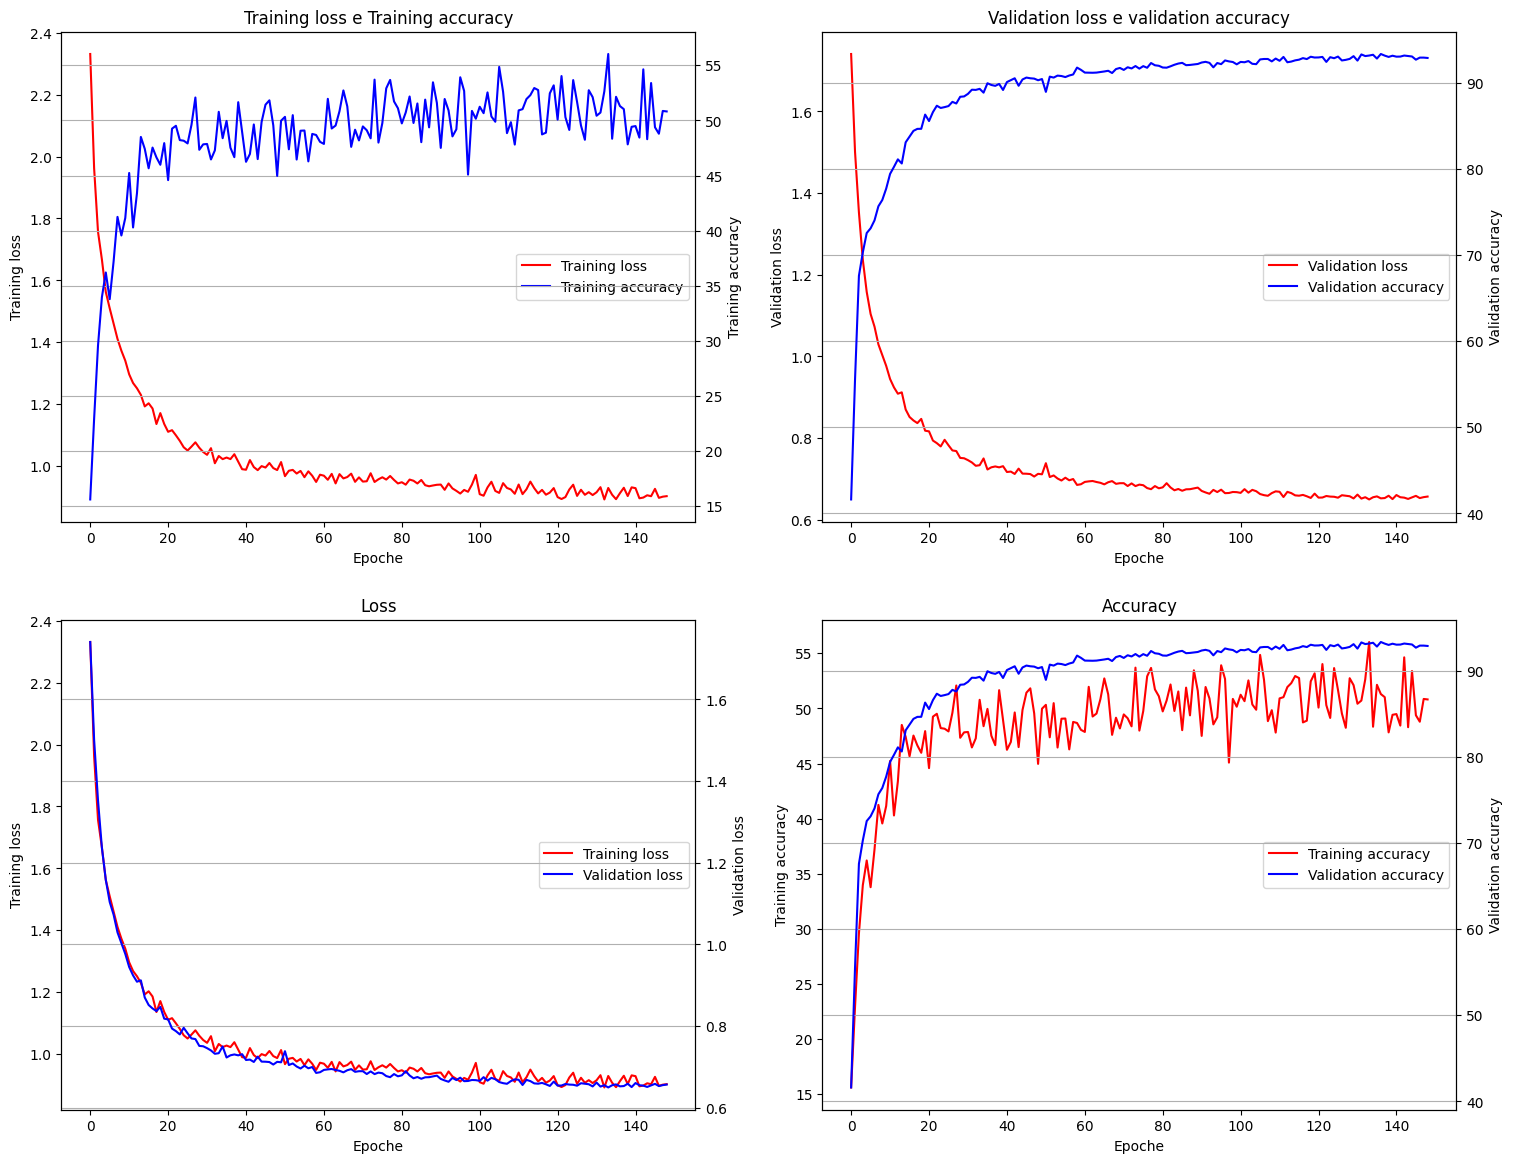

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18,14))

num_epochs = len(train_losses)
epoch_log = list(range(num_epochs))

def plot(ax,x,x_desc,x_twin,x_twin_desc,title,loc_legend=None):
    ax.set_title(title)

    ax_twin = ax.twinx()
    ax.plot(epoch_log,x,'r',label=x_desc)
    ax_twin.plot(epoch_log,x_twin,'b',label=x_twin_desc)

    ax.set_xlabel('Epoche')
    ax.set_ylabel(x_desc)
    ax_twin.set_ylabel(x_twin_desc)

    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax_twin.get_legend_handles_labels()
    tutte_le_linee = lines1 + lines2
    tutte_le_etichette = labels1 + labels2
    ax.legend(tutte_le_linee, tutte_le_etichette, loc=loc_legend)
    plt.grid()


plot(ax1,train_losses,"Training loss",train_accuracy,"Training accuracy","Training loss e Training accuracy","center right")
plot(ax2,val_losses,"Validation loss",val_accuracy,"Validation accuracy","Validation loss e validation accuracy","center right")
plot(ax3,train_losses,"Training loss",val_losses,"Validation loss","Loss","center right")
plot(ax4,train_accuracy,"Training accuracy",val_accuracy,"Validation accuracy","Accuracy","center right")

Dispositivo in uso: cuda
✅ Modello caricato con successo da /content/checkpoints/final_model.pth!


Test:   0%|          | 0/79 [00:00<?, ?it/s]


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1000
           1       0.99      0.99      0.99      1000
           2       0.90      0.92      0.91      1000
           3       0.94      0.94      0.94      1000
           4       0.90      0.92      0.91      1000
           5       0.99      0.98      0.99      1000
           6       0.83      0.79      0.81      1000
           7       0.95      0.99      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.99      0.96      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000


📈 Confusion Matrix:


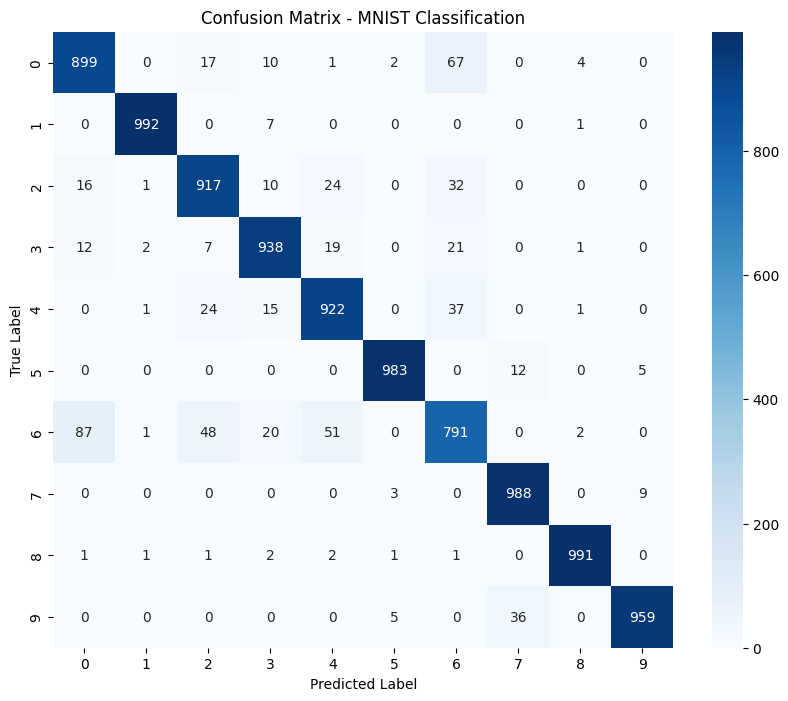


🎯 Test Accuracy: 93.80%


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo in uso: {device}")

model.to(device)

PATH_MODELLO = '/content/checkpoints/final_model.pth'

try:
    # Carica il checkpoint
    checkpoint = torch.load(PATH_MODELLO, map_location=device)

    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)

    print(f"✅ Modello caricato con successo da {PATH_MODELLO}!")

except FileNotFoundError:
    print(f"⚠️ File del modello non trovato in '{PATH_MODELLO}'. Verrà usato il modello con i pesi attuali...")
except Exception as e:
    print(f"❌ Errore nel caricamento del modello: {e}")


model.eval()

all_preds = []
all_labels = []


with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Test"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Calcolo gli ouput prodotti dal modello
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        # Riporta i risultati sulla CPU per le
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Converto le liste in array NumPy per le metriche di sklearn
all_preds_np = np.array(all_preds)
all_labels_np = np.array(all_labels)

# Stampa del classification report
print("\n📊 Classification Report:")
print(classification_report(all_labels_np, all_preds_np, target_names=[str(i) for i in range(10)]))

# Visualizzazione della matrice di confusione
print("\n📈 Confusion Matrix:")
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels_np, all_preds_np)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[str(i) for i in range(10)],
    yticklabels=[str(i) for i in range(10)]
)
plt.title('Confusion Matrix - MNIST Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calcolo e stampa dell'accuracy finale
test_accuracy = 100 * (all_preds_np == all_labels_np).sum() / len(all_labels_np)
print(f"\n🎯 Test Accuracy: {test_accuracy:.2f}%")